In [1]:
import pandas as pd
import numpy as np
import requests
import json
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix

# Leitura dos dados
### Existe um dataset para cada rank do jogo, eles são filtrados para que partidas com menos de 10 minutos não entrem, pois geralmente essas partidas são partidas onde um jogador caiu.

In [2]:
challengers = pd.read_csv('participants.csv')
challengers = challengers.loc[challengers['gameDuration'] > 1000]
gmaster = pd.read_csv('masterParticipants.csv')
gmaster = gmaster.loc[gmaster['gameDuration'] > 1000]
bronzes = pd.read_csv('bronzeParticipants.csv')
bronzes = bronzes.loc[bronzes['gameDuration'] > 1000]
golds = pd.read_csv('goldParticipants.csv')
golds = golds.loc[golds['gameDuration'] > 1000]
silver = pd.read_csv('silverParticipants.csv')
silver = silver.loc[silver['gameDuration'] > 1000]
iron = pd.read_csv('ironParticipants.csv')
iron = iron.loc[iron['gameDuration'] > 1000]
plat = pd.read_csv('platParticipants.csv')
plat = plat.loc[plat['gameDuration'] > 1000]
diamond = pd.read_csv('diamondParticipants.csv')
diamond = diamond.loc[diamond['gameDuration'] > 1000]

C:\Users\zenet\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (55,56) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\zenet\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1,6,7,8,9,10,11,55,56) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Separação dos ranks
### jogadores dos ranks Ferro (iron), Bronze e Prata (silver) estarão em um só dataset, Ouro (gold) Platina (plat) e Diamante (diamond) estarão em outro, e Grão-Mestre (grandmaster) e Desafiantes (challenger) estarão no último.

In [3]:
frames_1 = [iron, silver, bronzes]
bronzes = pd.concat(frames_1)
bronzes = bronzes.sample(frac=1)

In [4]:
frames_2 = [golds, plat, diamond]
golds = pd.concat(frames_2)
golds = golds.sample(frac=1)

In [5]:
gmaster['kills'] = gmaster['kills'].apply(int)
gmaster['deaths'] = gmaster['deaths'].apply(int)
gmaster['assists'] = gmaster['assists'].apply(int)
frames_3 = [challengers, gmaster]
challengers = pd.concat(frames_3)
challengers = challengers.sample(frac=1)

### Transformando atributo booleano em numeral

In [6]:
bronzes = bronzes.replace(True, 1).replace(False, 0)
golds = golds.replace(True, 1).replace(False, 0)
challengers = challengers.replace(True, 1).replace(False, 0)

### Returando todas as possíveis linhas duplicadas dos datasets

In [7]:
bronzes.drop_duplicates(inplace=True)
golds.drop_duplicates(inplace=True)
challengers.drop_duplicates(inplace=True)

### Adicionando uma nova coluna 'played' para conseguir contar quantas partidas de um dado jogador existem no dataset.

In [8]:
bronzes['played'] = 1
golds['played'] = 1
challengers['played'] = 1

### listas de atributos que serão utilizados no modelo

In [9]:
attr = ['totalHeal', 'totalMinionsKilled', 'neutralMinionsKilled', 'gameDuration', 'deaths', 'kills', 'visionScore', 'assists', 'goldEarned', 'inhibitorKills', 'totalDamageDealtToChampions', 'longestTimeSpentLiving', 'wardsKilled']
attr_plyd = ['totalHeal', 'totalMinionsKilled', 'neutralMinionsKilled', 'gameDuration', 'deaths', 'kills', 'visionScore', 'assists', 'goldEarned', 'inhibitorKills', 'totalDamageDealtToChampions', 'longestTimeSpentLiving', 'wardsKilled', 'played']

# Groupby dos datasets
### Para todos os atributos citados anteriormente é aplicada a função de média, menos para played, que é somado.
### Todas as linhas são agrupadas de modo em que tenhamos a media dos dados de todas as partidas que um dado jogador estava, apenas os seus status são utilizados.
### E por fim filtramos os jogadores para apenas ter dados de jogadores que tem mais de 3 partidas no dataset.

In [10]:
f = dict.fromkeys(bronzes[attr_plyd], 'mean')
f.update(
    dict.fromkeys(['played'], 'sum'))

In [11]:
bronzes_group = bronzes.groupby(['participantId'])[attr_plyd].agg(f)
golds_group = golds.groupby(['participantId'])[attr_plyd].agg(f)
challengers_group = challengers.groupby(['participantId'])[attr_plyd].agg(f)

In [12]:
bronzes_group = bronzes_group.loc[bronzes_group['played'] > 3]
golds_group = golds_group.loc[golds_group['played'] > 3]
challengers_group = challengers_group.loc[challengers_group['played'] > 3]

In [13]:
challengers_group['wardsKilled'] = challengers_group['wardsKilled'].fillna(0)
challengers_group

,totalHeal,totalMinionsKilled,neutralMinionsKilled,gameDuration,deaths,kills,visionScore,assists,goldEarned,inhibitorKills,totalDamageDealtToChampions,longestTimeSpentLiving,wardsKilled,played
participantId,,,,,,,,,,,,,,
--0Zw2Rlguez2dgs-FujbUJqsUjkJXjAGV2cbWkDUR8,3510.400000,126.000000,34.000000,1495.200000,5.200000,4.800000,17.400000,4.400000,9624.800000,0.200000,13681.000000,476.600000,2.400000,5
--Ju_A1b8ZlsnI5b8qovR9jFOOtJ4Ae1xmfIeX0V_ZBjqCsNQ3IshLwd,4780.944444,164.246032,18.960317,1579.063492,5.682540,4.523810,24.484127,6.198413,10626.079365,0.071429,15237.000000,534.357143,2.968254,126
--bUxb3LAeED-fpHRWdWa-C1WRaCqP5MJV6wy5h65oSJ,9012.991597,152.882353,17.268908,1587.344538,5.336134,6.100840,25.495798,7.546218,10789.487395,0.134454,17658.747899,552.285714,3.016807,119
-0Lkl8D8ElJldGfNYcUnVmkD0uGaFTfj9gfwJ5f50HV_guk,3357.144068,179.906780,14.084746,1635.338983,5.966102,6.915254,24.254237,7.449153,12019.889831,0.271186,18813.296610,593.381356,4.336283,118
-0QvxtwHrJvG4nwAeZMO6yLPb-tUpSWVFrQ6OP-FyCcbs2E,5037.091667,205.716667,13.033333,1674.158333,5.250000,6.208333,29.258333,7.575000,12485.958333,0.225000,19265.441667,577.508333,6.308333,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
znqUOlGVV0ouySxNrxJ6TGnTC-wGtx_ARiFcXsAQR_O2J1k,2174.250000,145.400000,1.800000,1585.000000,5.350000,4.250000,14.150000,5.900000,9204.100000,0.050000,15757.200000,579.450000,1.100000,20
zvD7hijK2ahBvybt5MGpIMDCDA-67aOpCWbFOF-O9-0ex-i8FERd1R1c,10969.000000,34.750000,102.750000,1710.500000,7.000000,4.750000,25.750000,8.500000,10546.250000,0.000000,12566.000000,435.250000,2.000000,4
zvuos5JaUwRW2h0dS93f8Hmw9vK9OsWQ21Rt7exmKZvV4DcAOyVvvMuY,11406.428571,19.904762,0.523810,1584.095238,4.666667,1.523810,59.380952,12.333333,7134.666667,0.095238,4759.666667,576.000000,7.904762,21


In [14]:
golds_group['wardsKilled'] = golds_group['wardsKilled'].fillna(0)
golds_group

,totalHeal,totalMinionsKilled,neutralMinionsKilled,gameDuration,deaths,kills,visionScore,assists,goldEarned,inhibitorKills,totalDamageDealtToChampions,longestTimeSpentLiving,wardsKilled,played
participantId,,,,,,,,,,,,,,
--PHF31hgpC3YNiXSWHgrmeEUwWwtF-XQTnmK_jpztS2Rgk,6947.394737,114.921053,57.894737,1708.578947,5.710526,7.342105,21.684211,9.026316,11733.447368,0.368421,18741.921053,589.210526,2.837838,38
-06zAh6cA_jW7uJ3z2VbrQLBdGO1fUL631dmF3kXdKynehk,4391.250000,179.500000,14.000000,1763.750000,5.000000,9.750000,36.250000,10.750000,14096.000000,1.500000,27913.500000,480.250000,6.500000,4
-0ScFmyMljw3v5XBMnUeIyuIAUAb2OLLZtWmdB3w3gqeS6A,7611.363636,14.545455,0.727273,1729.090909,5.363636,2.818182,42.363636,15.090909,8351.545455,0.090909,11227.363636,593.545455,3.454545,11
-1nnnhBb-k-PBj5ufy8K4K4Va7STmQAssU6EHlSE8HvnzlQ,5779.250000,21.875000,1.500000,1795.250000,5.125000,2.500000,56.000000,13.125000,8376.250000,0.125000,7866.875000,656.875000,7.375000,8
-2QIden8EaJ-ZFLLijgQewrfqXGorW6jyRVQJ6jWtPD8nQ,4967.500000,93.000000,43.500000,1460.750000,4.750000,4.000000,13.500000,4.000000,8860.500000,0.000000,11256.750000,594.500000,1.750000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zu9GWTy4WwPlt1gpgJldYvH-_kjKDekVRueys5wFugAg-jo,5893.076923,44.538462,0.307692,1369.384615,7.153846,9.230769,5.000000,15.923077,13315.153846,0.076923,17461.461538,290.384615,3.000000,13
zuOuyE-1WaQA3nJgoqAqXYGHSZZSDkJQfhPk28DWOgeI7gI,2421.800000,187.800000,4.400000,1871.200000,5.000000,4.400000,27.400000,8.800000,11706.800000,0.600000,16686.000000,521.000000,2.400000,5
zv25akoraBj7typ8b4M8U1SlqtELrBmJOJAzQ-TjNFKzVki4lnpIwviA,1670.285714,149.571429,2.000000,1845.285714,5.857143,5.714286,15.285714,7.857143,11234.571429,0.142857,20726.000000,544.714286,0.714286,7


In [15]:
bronzes_group['wardsKilled'] = bronzes_group['wardsKilled'].fillna(0)
bronzes_group

,totalHeal,totalMinionsKilled,neutralMinionsKilled,gameDuration,deaths,kills,visionScore,assists,goldEarned,inhibitorKills,totalDamageDealtToChampions,longestTimeSpentLiving,wardsKilled,played
participantId,,,,,,,,,,,,,,
--FbpA7gTbekOLOCUZoqhS1Bv5EjMRf3uTuvmqfTHZbAgEw,5864.250000,62.750000,44.000000,1546.000000,3.750000,5.000000,11.750000,5.750000,8473.750000,0.000000,8462.500000,678.000000,1.250000,4
-0Q-_o74AnxzeXU2lFnJSe96hZRs54C19UGu7dV5jcVZ-pALTUsHHd02,4131.250000,134.250000,2.000000,1859.500000,8.500000,5.750000,19.000000,5.250000,10342.250000,0.250000,17646.500000,538.500000,1.000000,4
-1H4fHNvmGKv4J0c2zmgLBYh2vUs0aqjFU5M7NJipsIVpZk,3996.750000,76.222222,17.166667,1605.166667,6.500000,5.805556,22.111111,10.277778,10536.944444,0.111111,12838.055556,530.111111,2.653846,36
-3cNs-QB9rKoDaJNMKwvX4-KU5u8SGQ6b-jAIr9nhyFHZmsbTdSS5ce2,11842.000000,99.750000,60.500000,2065.250000,6.750000,4.250000,18.500000,4.250000,11059.500000,0.250000,13323.000000,857.000000,1.000000,4
-698_JdygJ7AlHg6pMpUpAkHKp5o6YnYredy0fj7Otk,2710.000000,149.800000,15.400000,1907.000000,8.600000,7.200000,12.400000,6.000000,11897.800000,0.000000,20227.400000,627.400000,0.600000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
znMyMqTTtvNQzAMBnq_dFuGM9NdSVKORInRbRnOqHZc0YlcUOI_5SU67,12688.833333,51.333333,121.833333,2153.166667,7.166667,12.500000,16.000000,7.000000,14171.833333,0.166667,22033.000000,685.500000,1.000000,6
zoYr-x3WZWBmY-3YDhgpoLtAaJSeVmeBqs3BqlvwrKtxCwP6cikTTRKC,8471.500000,47.500000,52.750000,1374.750000,4.500000,4.000000,12.000000,5.750000,7413.750000,0.000000,9930.000000,412.250000,0.500000,4
zuuVlfoRJ89LX-vEcP1ti1uYEyUExUTVXilTSxOAFx2PVnM,9729.142857,86.857143,10.000000,1564.857143,9.142857,8.857143,7.000000,8.285714,15038.714286,0.142857,24735.142857,335.142857,0.000000,7


# Separação dos ranks
### o primeiro dataset contendo bronze, prata e ferro recebe o tier 1, o dataset com ouro, platina e diamante o tier 2 e o dataset com desafiante e grão mestre recebe o tier 3, o mais alto.
### após isso, os datasets são unidos, formando apenas um dataset com todos os jogadores.

In [16]:
bronzes_group['tier'] = 1
golds_group['tier'] = 2
challengers_group['tier'] = 3

In [17]:
frames = [bronzes_group,golds_group,challengers_group]
df = pd.concat(frames)
df = df.sample(frac=1)
df

,totalHeal,totalMinionsKilled,neutralMinionsKilled,gameDuration,deaths,kills,visionScore,assists,goldEarned,inhibitorKills,totalDamageDealtToChampions,longestTimeSpentLiving,wardsKilled,played,tier
participantId,,,,,,,,,,,,,,,
0KzAdELb5AhhXOJnsLxLfnqP_rlfOSQWyihPpotAUtjs6oA,10497.750000,88.500000,79.250000,1683.500000,8.500000,6.500000,19.250000,6.000000,11346.250000,0.500000,15165.000000,462.500000,1.750000,4,2
cEXB0ayfT4guqAz9QnXU2bbHCXMqRsYZ4fyv5Ga5dxVsW9Y,3187.411765,122.794118,3.617647,1769.205882,6.235294,5.500000,9.117647,4.176471,9679.235294,0.117647,12668.794118,594.000000,0.352941,34,1
_KTwzv4Yz_COpI6Z95rZiXkoXPXhDLXJPKSPTerzXOqFY2QBVHsJCKIm,2774.333333,38.333333,0.000000,1252.888889,8.666667,3.888889,0.000000,20.111111,12399.666667,0.000000,16608.111111,286.333333,0.000000,9,1
m_iRVnThalIF2D5gwzRqfqu4ZGElDnx3v25m47GBFPRgsvA,3179.533333,63.333333,8.600000,1541.400000,9.266667,4.666667,13.133333,9.133333,10050.666667,0.333333,11771.600000,328.666667,0.800000,15,2
YPi_IdSqSJQIPxUdtpeyQrwuxAZZK-6lGUD4nc1n98a_esE,4208.586207,35.172414,0.000000,1316.517241,13.241379,10.448276,0.000000,20.379310,14435.655172,0.034483,25680.724138,172.827586,0.000000,29,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21Jqk6K_vaj-O2IP5IXe4Z8SikMwxRuBrVYiBnLHvUCX2ic8wsmcRHMy,12479.000000,19.200000,113.600000,1759.200000,6.000000,5.800000,21.800000,10.000000,10042.800000,0.000000,15282.800000,612.200000,1.600000,5,1
3Bytbs1daYtRDXPyh-e9yM1PB3WjQOM4-IjIwypkVmKtdGFKxavmToPM,5308.000000,163.285714,5.857143,1794.142857,8.142857,9.000000,21.714286,5.714286,12027.142857,0.142857,21633.142857,426.714286,1.857143,7,2
mbatTYE9_aPWodOAyhqW3NNsZlo0YpDe5jOpS2i0coZZCzM,1805.375000,89.062500,6.125000,1676.187500,7.062500,3.125000,13.625000,8.375000,8598.625000,0.125000,12118.937500,525.812500,1.625000,16,2


# Predição
### Primeiro os dados são distribuídos entre teste e treino.
### Depois o algoritmo de random forest é utilizado para a predição, tendo uma acurácia de 73.36%.
### Seguido  do algoritmo KNN que teve uma acurácia de 65.49%.
### E por fim, o algoritmo de naive bayes que teve uma acurácia de 63.50%.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df[attr], df['tier'], test_size=0.2)

In [20]:
from sklearn import metrics
clf=RandomForestClassifier(n_estimators=700, max_features='log2')
classifier = clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7336729967577582


In [21]:
from sklearn.neighbors import KNeighborsClassifier
model2 = KNeighborsClassifier(n_neighbors=2)
model2.fit(X_train,y_train)
predicted2= model2.predict(X_test)
print("Predicted Value:", predicted2)
print("Accuracy:",metrics.accuracy_score(y_test, predicted2))

Predicted Value: [2 2 3 ... 2 2 1]
Accuracy: 0.6549328392774433


In [22]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train,y_train)
predicted= model.predict(X_test)
print("Predicted Value:", predicted)
print("Accuracy:",metrics.accuracy_score(y_test, predicted))

Predicted Value: [2 3 3 ... 2 2 1]
Accuracy: 0.635016211208893


### Nossa escolha foi de utilizar o modelo com o random forest devido o sucesso do algoritmo.

# Visualização do modelo.
### Abaixo podemos ver a importância de cada um dos atributos para o random forest, o interessante é perceber a importância que a visão tem no jogo, tendo wardsKilled em primeiro e VisionScore em quarto.

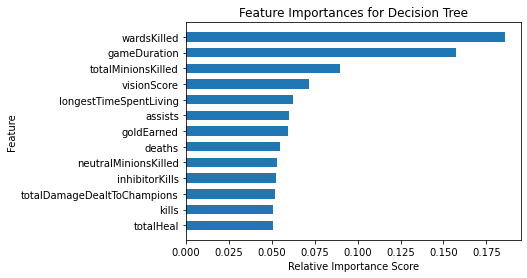

In [23]:
rf_feature_importances = clf.feature_importances_
rf_feature_names, rf_feature_scores = zip(*sorted(zip(attr, rf_feature_importances), 
                                                          key=lambda x: x[1]))
y_position = list(range(len(rf_feature_names)))
plt.barh(y_position, rf_feature_scores, height=0.6, align='center')
plt.yticks(y_position , rf_feature_names)
plt.xlabel('Relative Importance Score')
plt.ylabel('Feature')
t = plt.title('Feature Importances for Decision Tree')

# Matriz de confusão

### Abaixo podemos visualizar a matriz de confusão, importante perceber que quase não há classificações de tier 1 como 3 ou tier 3 como 1.

[[520 115  10]
 [ 85 646 118]
 [ 11 236 418]]


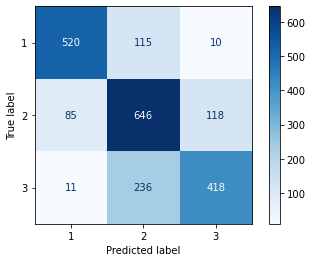

In [24]:
disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=['1','2','3'],
                                 cmap=plt.cm.Blues,
                                 normalize=None)

print(disp.confusion_matrix)